In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split

from src.modeling import build_logistic_model
from src.evaluation import evaluate_roc_auc, evaluate_classification_metrics

In [2]:
df = pd.read_csv("../data/processed/lending_club_clean.csv")

X = df.drop("default_flag", axis=1)
y = df["default_flag"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [4]:
log_model = build_logistic_model()
log_model.fit(X_train, y_train)

log_auc = evaluate_roc_auc(log_model, X_test, y_test)
log_metrics = evaluate_classification_metrics(log_model, X_test, y_test)

In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_auc = evaluate_roc_auc(rf_model, X_test, y_test)
rf_metrics = evaluate_classification_metrics(rf_model, X_test, y_test)


gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)
gb_auc = evaluate_roc_auc(gb_model, X_test, y_test)
gb_metrics = evaluate_classification_metrics(gb_model, X_test, y_test)

In [6]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "ROC_AUC": [log_auc, rf_auc, gb_auc],
    "Accuracy": [
        log_metrics["Accuracy"],
        rf_metrics["Accuracy"],
        gb_metrics["Accuracy"]
    ],
    "Precision": [
        log_metrics["Precision"],
        rf_metrics["Precision"],
        gb_metrics["Precision"]
    ],
    "Recall": [
        log_metrics["Recall"],
        rf_metrics["Recall"],
        gb_metrics["Recall"]
    ],
    "F1_Score": [
        log_metrics["F1_Score"],
        rf_metrics["F1_Score"],
        gb_metrics["F1_Score"]
    ]
})

comparison.sort_values("ROC_AUC", ascending=False)

,Model,ROC_AUC,Accuracy,Precision,Recall,F1_Score
2,Gradient Boosting,0.723183,0.807754,0.572779,0.078017,0.137329
1,Random Forest,0.720622,0.806037,0.641447,0.025105,0.048318
0,Logistic Regression,0.705570,0.804863,0.517409,0.075571,0.131880


In [7]:
# Save final chosen model
joblib.dump(log_model, "../outputs/model/best_model.pkl")

print("Best model (Logistic Regression) saved successfully.")

Best model (Logistic Regression) saved successfully.


## Final Model Selection

### Model Performance Summary

| Model | ROC-AUC | Accuracy | Precision | Recall | F1-Score |
|-------|---------|----------|-----------|--------|----------|
| Gradient Boosting | 0.723 | 0.808 | 0.573 | 0.078 | 0.137 |
| Random Forest | 0.721 | 0.806 | 0.641 | 0.025 | 0.048 |
| Logistic Regression | 0.706 | 0.805 | 0.517 | 0.076 | 0.132 |

### Performance Interpretation

- Gradient Boosting achieves the highest ROC-AUC (0.723).
- However, recall at threshold 0.5 is low across all models (2.5–7.8%), reflecting class imbalance.
- The AUC improvement over Logistic Regression is modest (~0.015–0.018).

This indicates that raw classification metrics at default threshold are not sufficient for credit portfolio decision-making.

---

### Model Selection Rationale

Although ensemble models slightly outperform in ROC-AUC, **Logistic Regression is selected as the production model** based on the following considerations:

**1. Transparency**

Logistic Regression follows a parametric structure:

$$
P(Default) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + ... + \beta_nX_n)}}
$$

Each variable contributes additively to log-odds, enabling full transparency and auditability.

**2. Interpretability**

The model provides:

- Clear coefficient estimates  
- Directional impact of risk drivers  
- Odds ratio interpretation  

This supports credit committee reporting, internal validation, and regulatory documentation.

**3. Regulatory Alignment**

In Basel-aligned PD modeling environments:

- Logistic Regression and scorecard-based approaches are widely used.
- Transparent parametric models reduce validation and audit burden.
- Structural simplicity lowers model risk.

Given the marginal AUC improvement from ensemble methods, added complexity is not justified.

---

### Model Risk Management Perspective

Model selection must balance predictive performance and governance.

Logistic Regression offers:

- Stable parameter estimates  
- Easier recalibration and monitoring  
- Straightforward sensitivity analysis  
- Lower structural model risk  

---

### Threshold Consideration

Low recall at threshold 0.5 highlights the need for probability-based scoring rather than direct classification.

Therefore, the final framework applies:

- PD estimation  
- Threshold optimization  
- Portfolio-level tradeoff analysis  

This business-driven threshold selection is implemented in the scoring phase.

---

### Final Decision

Considering interpretability, regulatory alignment, model governance, and marginal performance differences:

**Logistic Regression is selected as the final production model for scoring and portfolio monitoring.**

Random Forest and Gradient Boosting are retained as benchmark models.

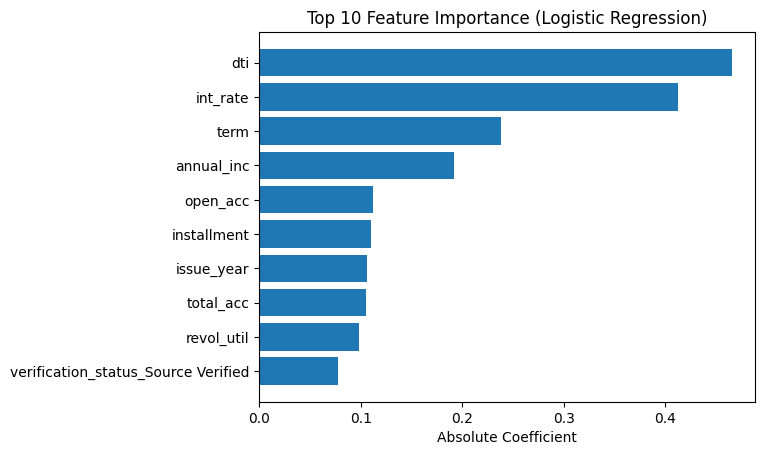

,Feature,Coefficient,Abs_Coefficient
6,dti,0.465401,0.465401
2,int_rate,0.412795,0.412795
1,term,0.238121,0.238121
5,annual_inc,-0.191904,0.191904
7,open_acc,0.111666,0.111666
3,installment,0.110363,0.110363
14,issue_year,0.105928,0.105928
11,total_acc,-0.104975,0.104975
10,revol_util,0.098653,0.098653
21,verification_status_Source Verified,0.077723,0.077723


In [7]:
# Take the logistic regression model from the pipeline
log_reg = log_model.named_steps["model"]

# Take the coefficients and feature names
coefficients = log_reg.coef_[0]
features = X_train.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
})

# Order by absolute coefficient
importance_df = importance_df.sort_values(by="Abs_Coefficient", ascending=False)

# Take top 10 features
top_features = importance_df.head(10)

# Plot
plt.figure()
plt.barh(top_features["Feature"], top_features["Abs_Coefficient"])
plt.xlabel("Absolute Coefficient")
plt.title("Top 10 Feature Importance (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()

importance_df.head(10)

### Model Interpretability – Key Risk Drivers

The Logistic Regression model indicates that the primary drivers of default probability are:

- **Debt-to-Income Ratio (DTI)** – strongest predictor of default risk.
- **Interest Rate** – higher borrowing cost significantly increases risk.
- **Loan Term** – longer maturities expose the portfolio to higher uncertainty.
- **Annual Income** – higher income reduces default probability.

These findings align with fundamental credit risk theory, where leverage, borrowing cost, and repayment capacity are key determinants of creditworthiness.